In [17]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Reshape
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Rescaling
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator

In [18]:
os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=/usr/lib/cuda"
os.environ['TF_GPU_ALLOCATOR'] = "cuda_malloc_async"
os.system('echo $XLA_FLAGS')
os.system('echo $TF_GPU_ALLOCATOR')

--xla_gpu_cuda_data_dir=/usr/lib/cuda
cuda_malloc_async


0

In [19]:
print(tf.__version__)

2.13.0


In [20]:
data_dir = pathlib.Path('./Datasets/lung/').with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1097


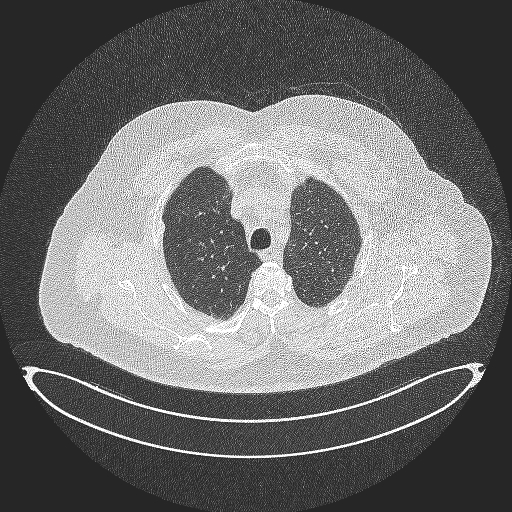

In [21]:
bengin=list(data_dir.glob('Normal cases/*'))
PIL.Image.open(str(bengin[1]))

In [22]:
# train_ds=ImageDataGenerator(zoom_range=0.2,shear_range=0.2,rescale=1/255,horizontal_flip=True).flow_from_directory(directory=path,target_size=(512,512),batch_size=)
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(512, 512),
  batch_size=32)

Found 1097 files belonging to 3 classes.
Using 768 files for training.


In [23]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [24]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(512, 512),
  batch_size=32)

Found 1097 files belonging to 3 classes.
Using 329 files for validation.


In [25]:
class_names_ = train_ds.class_names # type: ignore
print(class_names_)

['Bengin cases', 'Malignant cases', 'Normal cases']


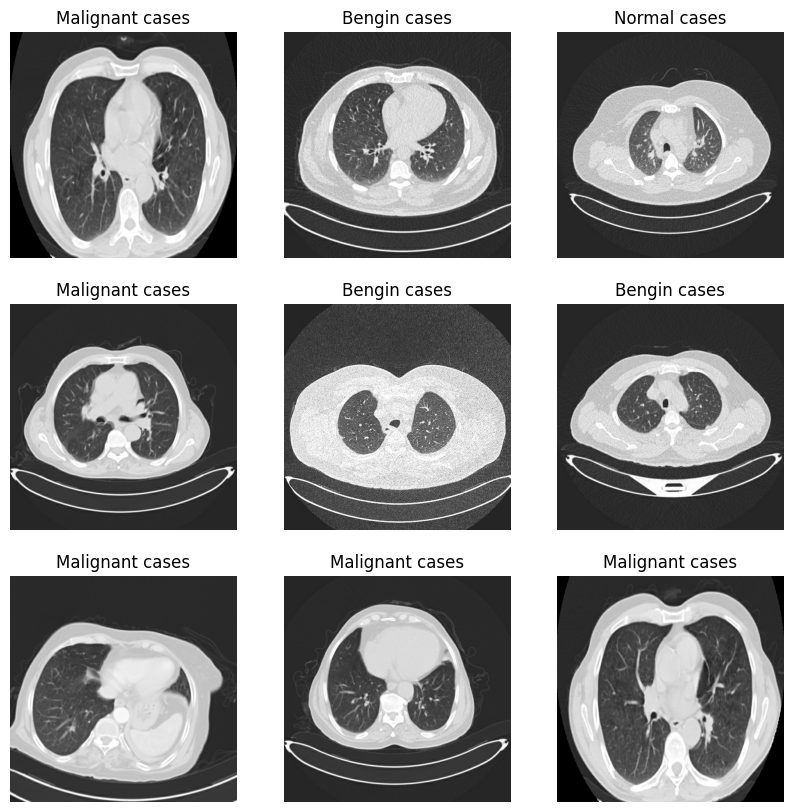

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # type: ignore
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names_[labels[i]])
    plt.axis("off")

In [27]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 512, 512, 3)
(32,)


In [28]:
num_classes = 2

# model = tf.keras.Sequential([
#   tf.keras.layers.Rescaling(1./255),
#   tf.keras.layers.Conv2D(4, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(4, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(4, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(32, activation='relu'),
#   tf.keras.layers.Dense(num_classes)
# ])
model=Sequential()
model.add(Conv2D(filters= 8,kernel_size=(3,3),activation='relu',input_shape=(512,512,3)))
model.add(Conv2D(filters= 24,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters= 72,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(units=64,activation='relu'))
# model.add(Dropout(rate=0.25))
model.add(Dense(3))
model.summary()
# model=Sequential()
# model.add(Conv2D(32,(3,3),activation='relu',input_shape=(512,512,3)))
# model.add(MaxPool2D(2,2))
# model.add(Flatten())
# model.add(Dense(100,activation='relu'))
# model.add(Dense(10,activation='softmax'))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 510, 510, 8)       224       
                                                                 
 conv2d_5 (Conv2D)           (None, 508, 508, 24)      1752      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 254, 254, 24)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 252, 252, 72)      15624     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 126, 126, 72)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 124, 124, 128)    

In [29]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
es=EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=4,verbose=1,mode='auto')
mc=ModelCheckpoint(monitor="val_accuracy",filepath="./bestmodel.h5",verbose=1,save_best_only=True,mode='auto')
cd=[es,mc]

In [30]:
AUTOTUNE = tf.data.AUTOTUNE
classes=list(train_ds.class_names) 
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE) # type: ignore
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) # type: ignore

In [31]:

# from tensorflow.keras.optomize import
model.compile(
  optimizer='adam',
  # optimizer=SGD(learning_rate=1e-4, momentum=0.9),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  # loss='categorical_crossentropy',
  metrics=['accuracy'])
# print(tf.keras.metrics.SensitivityAtSpecificity(0.5, class_id=None, name=None, dtype=None))
m = tf.keras.metrics.SensitivityAtSpecificity(
        0.4, num_thresholds=200)
m.update_state([0, 0, 1, 1], [0, 0.5, 0.3, 0.9])
print('Result with num_thresholds = %d: %.1f' %(200, m.result().numpy()))

Result with num_thresholds = 200: 1.0


In [32]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=cd
)

# model.summary()

Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 342.0053 - accuracy: 0.4661
Epoch 1: val_accuracy improved from -inf to 0.70213, saving model to ./bestmodel.h5


/home/star/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 23s 920ms/step - loss: 342.0053 - accuracy: 0.4661 - val_loss: 0.7616 - val_accuracy: 0.7021
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.3289 - accuracy: 0.8958
Epoch 2: val_accuracy improved from 0.70213 to 0.96960, saving model to ./bestmodel.h5
24/24 [==============================] - 11s 454ms/step - loss: 0.3289 - accuracy: 0.8958 - val_loss: 0.0698 - val_accuracy: 0.9696
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.0298 - accuracy: 0.9870
Epoch 3: val_accuracy improved from 0.96960 to 0.97264, saving model to ./bestmodel.h5
24/24 [==============================] - 11s 478ms/step - loss: 0.0298 - accuracy: 0.9870 - val_loss: 0.1089 - val_accuracy: 0.9726
Epoch 4/10
24/24 [==============================] - ETA: 0s - loss: 0.0481 - accuracy: 0.9870
Epoch 4: val_accuracy improved from 0.97264 to 0.98176, saving model to ./bestmodel.h5
24/24 [==============================] - 14s 599ms/step - l

In [34]:
from keras.preprocessing.image import load_img,img_to_array
path="./Datasets/lung/Bengin cases/Bengin case (9).jpg"
img=load_img(path,target_size=(512,512))
arr=img_to_array(img)
# arr.shape
arr=np.expand_dims(arr,axis=0)
pred=model.predict(arr)
pred_1=list(pred[0])
print(pred_1)
ans=list(classes)
print(ans)
print(ans[pred_1.index(max(pred_1))])

1/1 [==============================] - 0s 13ms/step
[3.0254383, -10.445552, -11.631222]
['Bengin cases', 'Malignant cases', 'Normal cases']
Bengin cases
